   Phase  Zyklus  Mode MType      Zeit  Sollgeschw.  Gang  THC.PrePrimCat  \
0      1       1     1     C  0.416415          0.0     0         632.905   
1      1       1     1     C  1.409310          0.0     0       10360.700   
2      1       1     1     C  2.412160          0.0     0        9520.890   
3      1       1     1     C  3.409370          0.0     0        7654.280   
4      1       1     1     C  4.409430          0.0     0        7863.540   

   THC.TailPipe  THC.PrePrimCat.mass  ...  NOX.Dil.mass.IntSum  CO2.Dilute  \
0       17.4109             0.000158  ...              0.00000      254.72   
1     1465.9800             0.002273  ...              0.00000      256.67   
2     6862.3400             0.002113  ...              0.00000      256.78   
3     8024.8800             0.001698  ...              0.00006      253.58   
4     7655.3600             0.001742  ...              0.00010      256.33   

   CO2.Dilute.mass  CO2.Dil.mass.IntSum     Liter  Distance_1  Dista

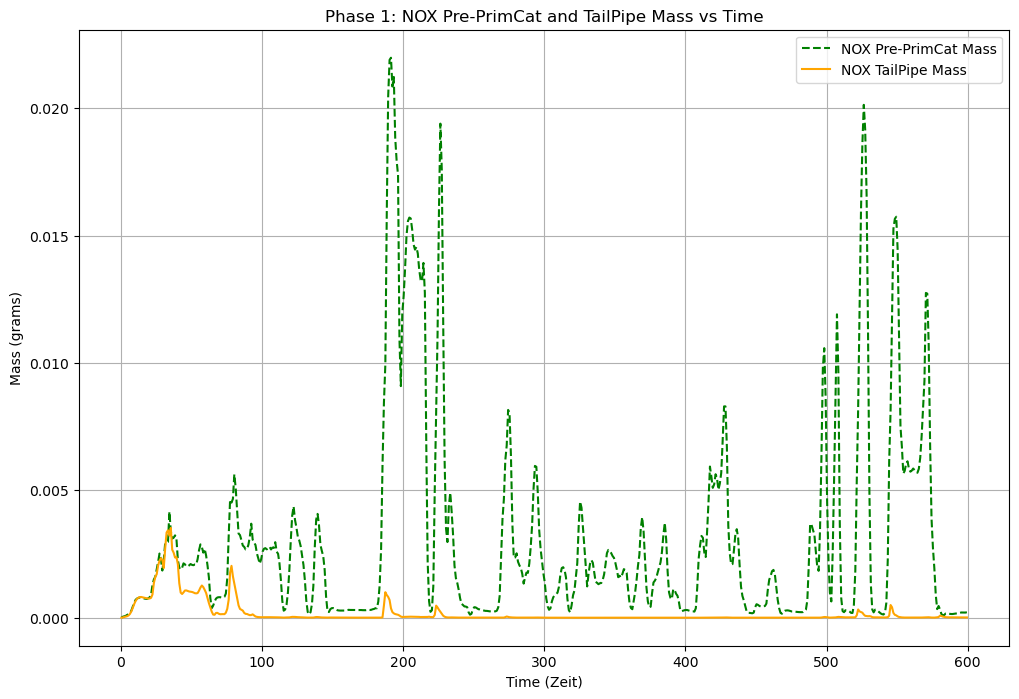

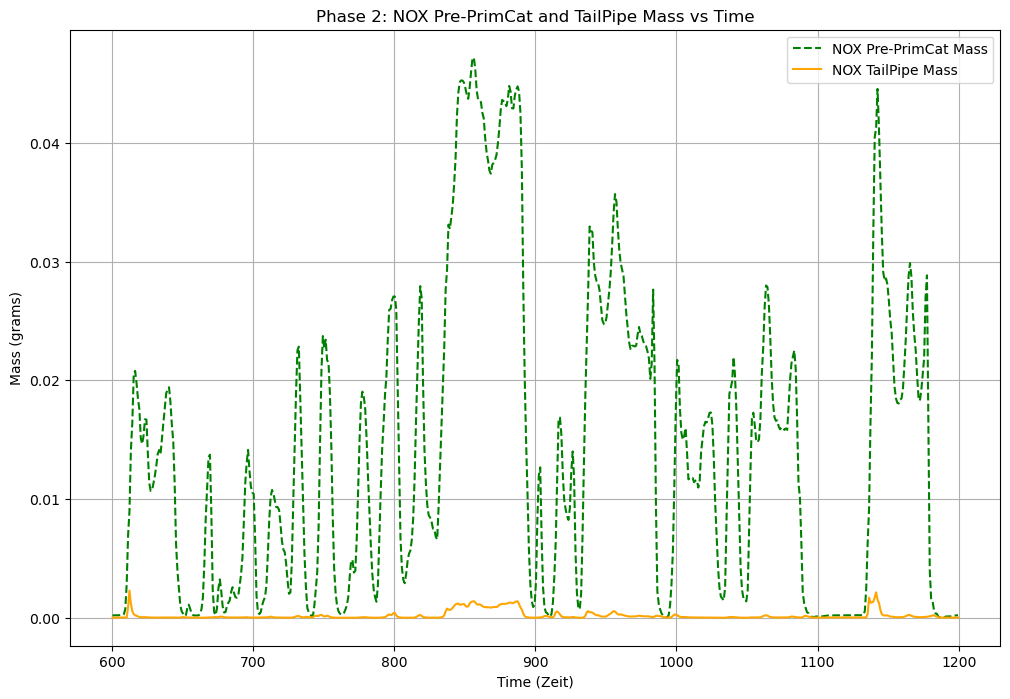

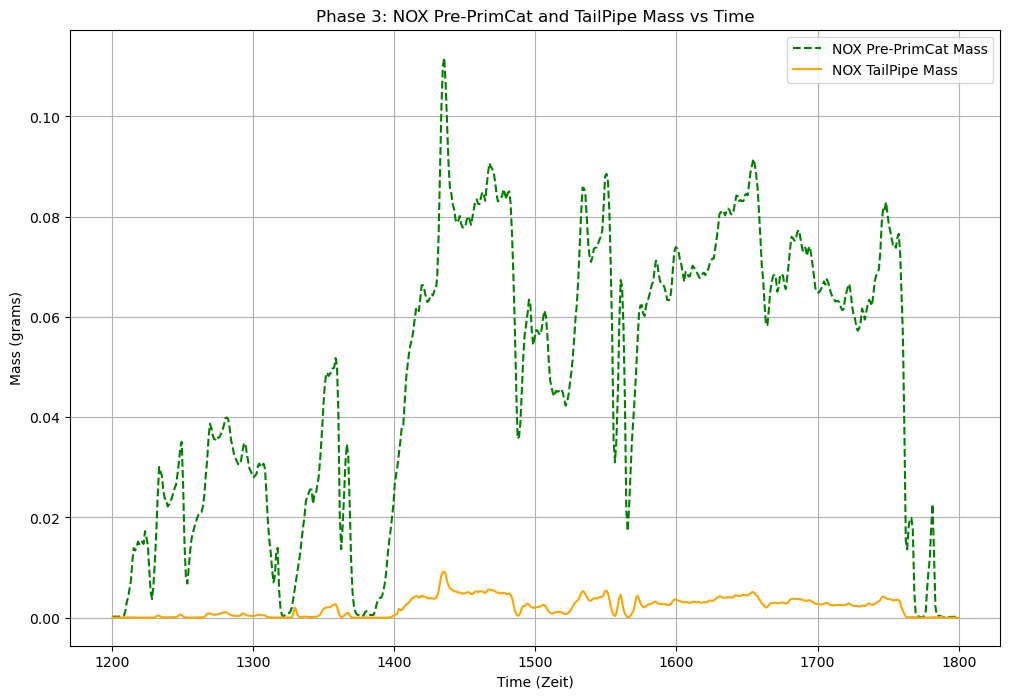

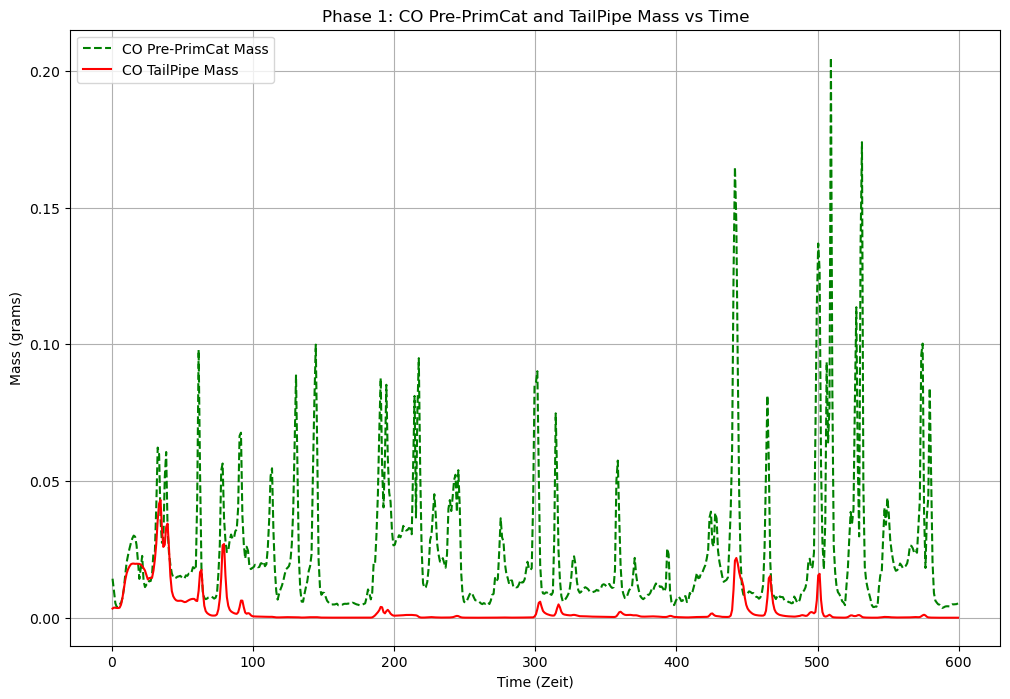

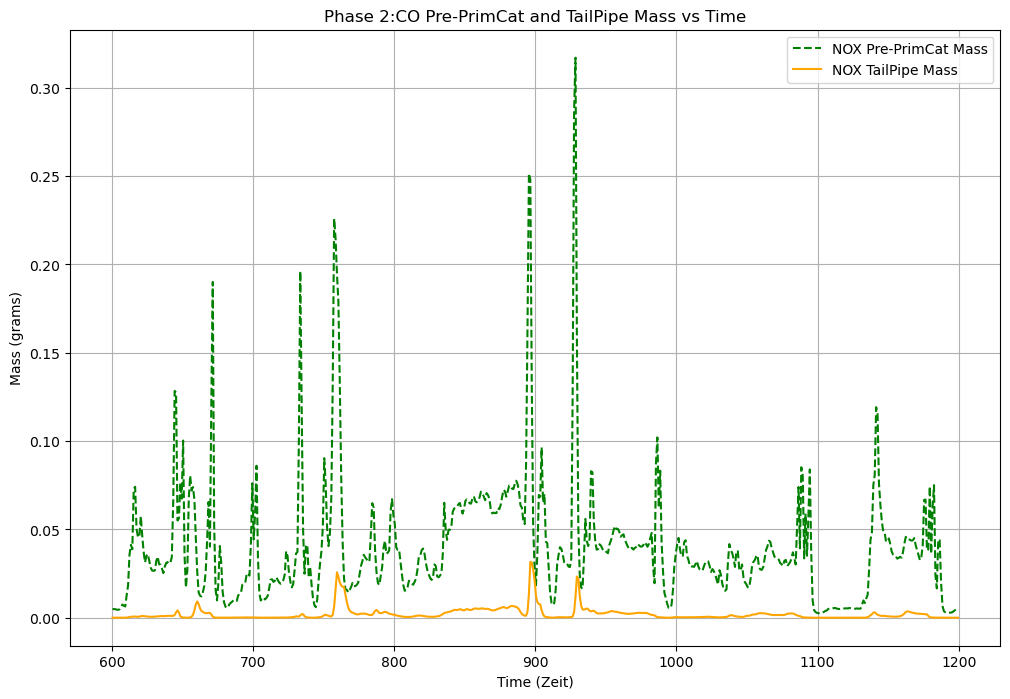

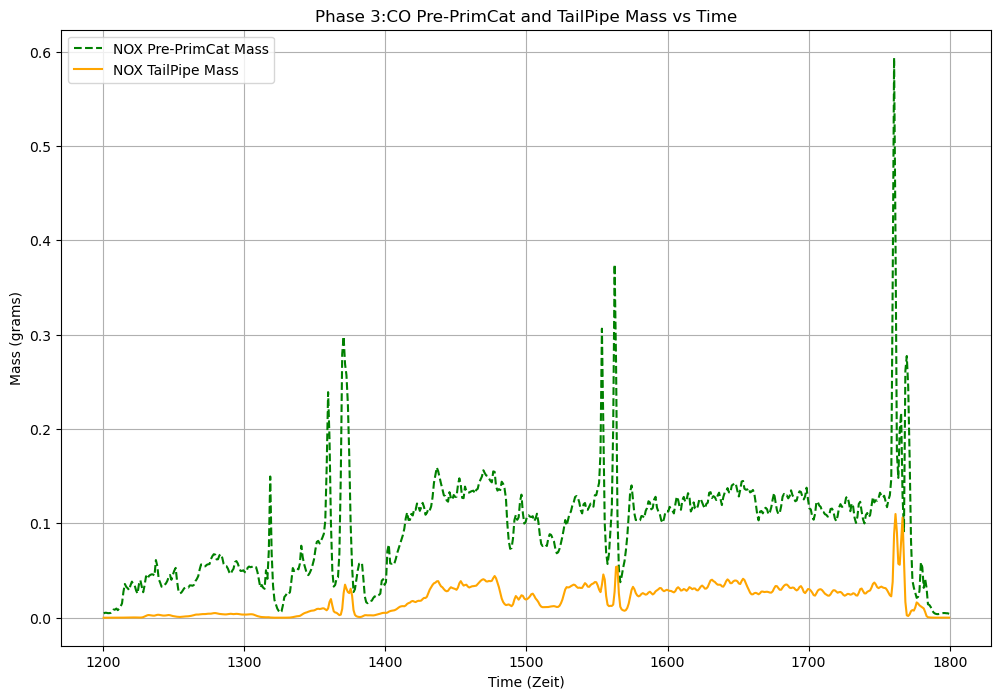

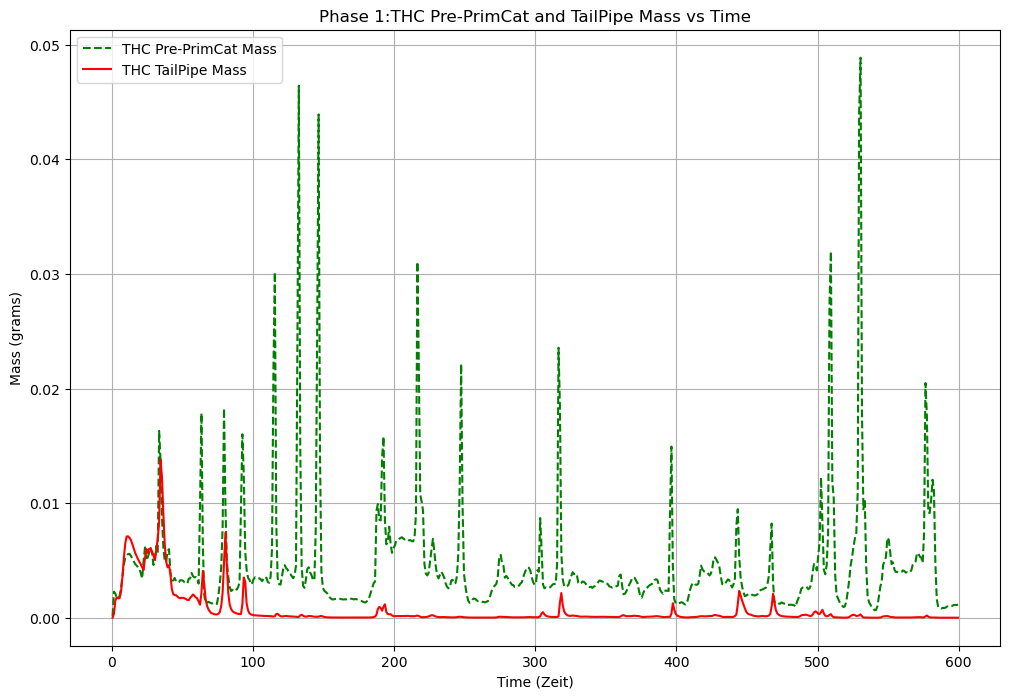

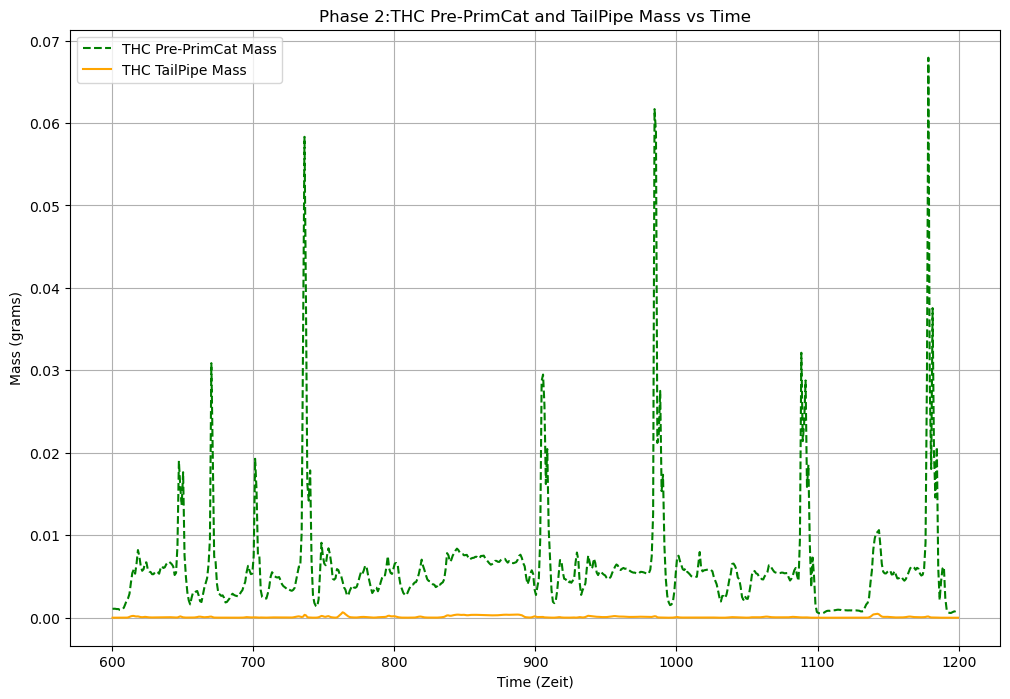

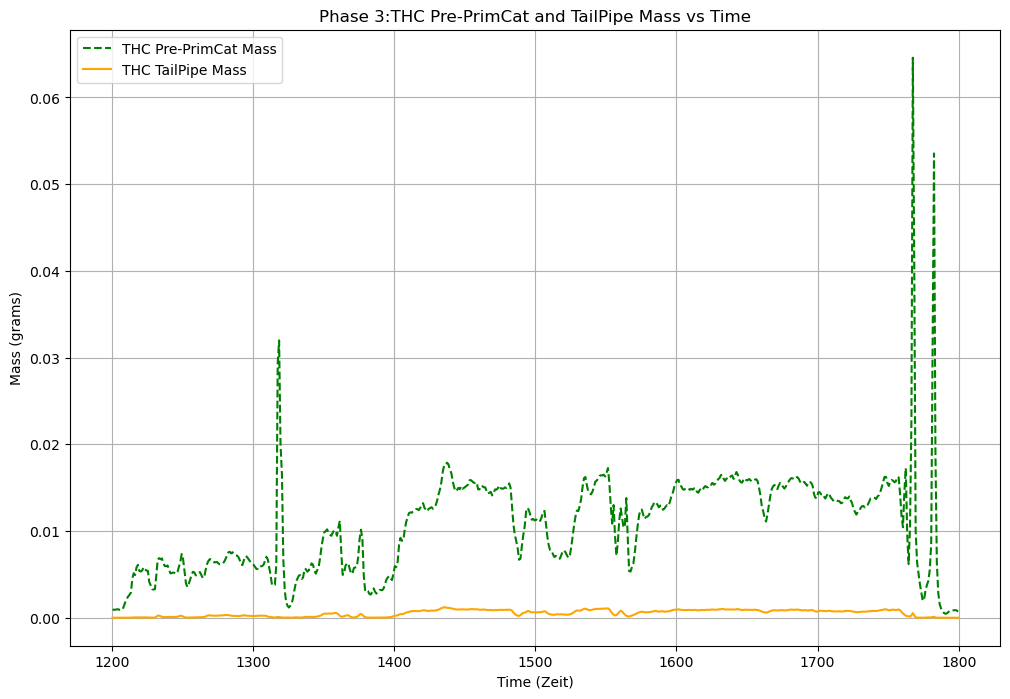

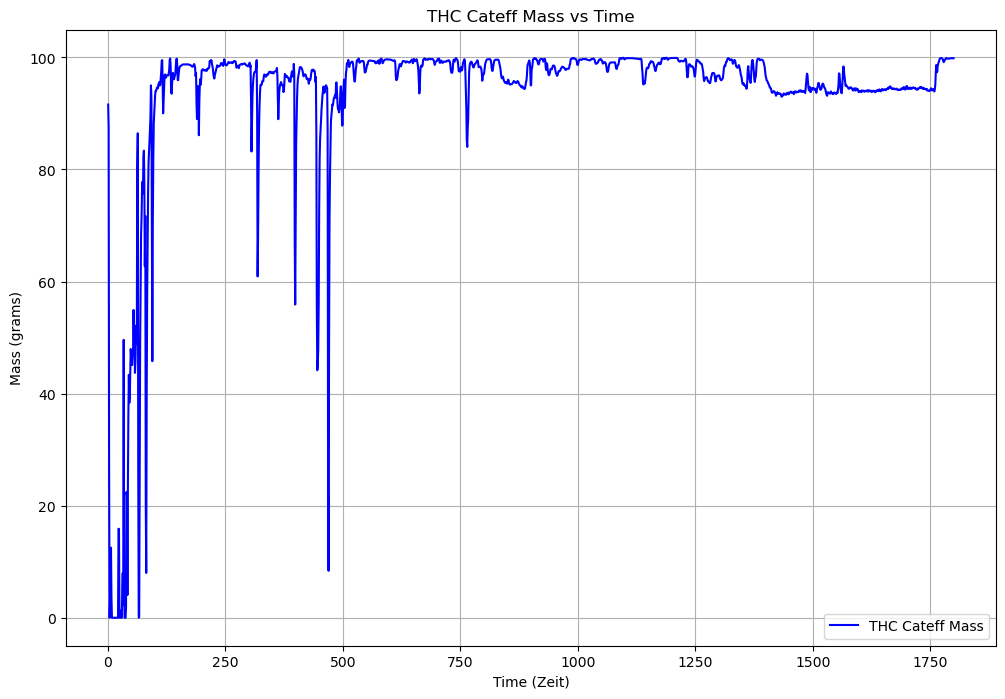

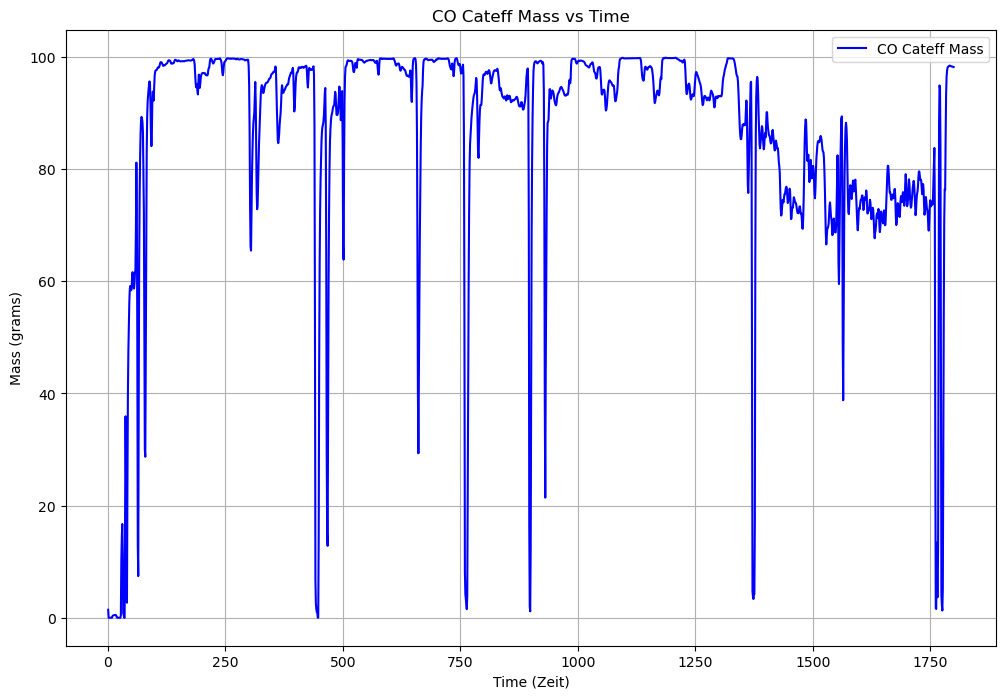

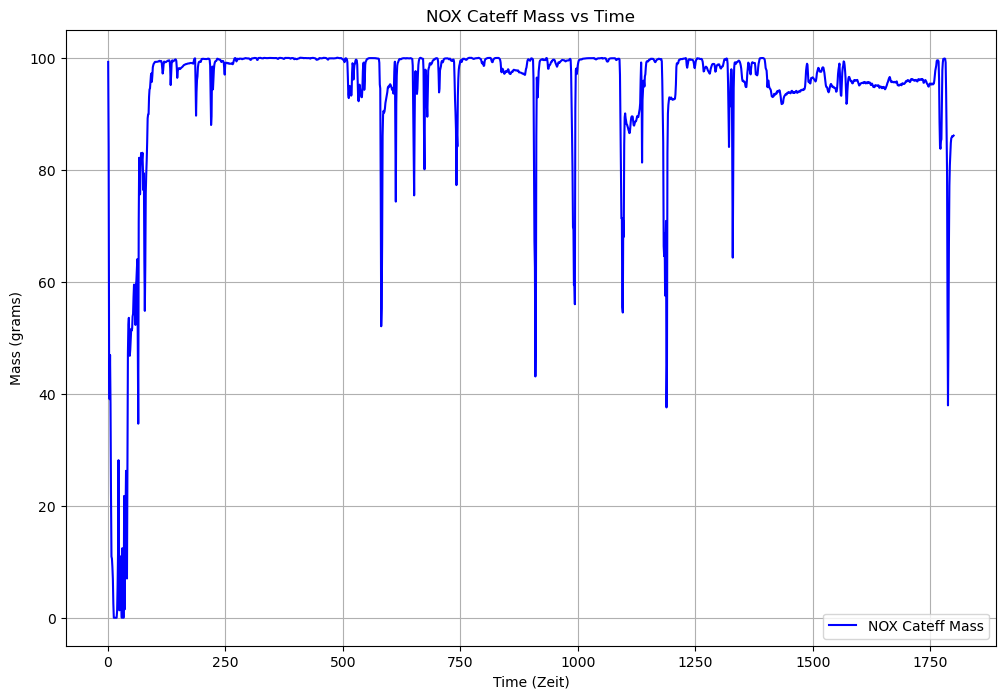

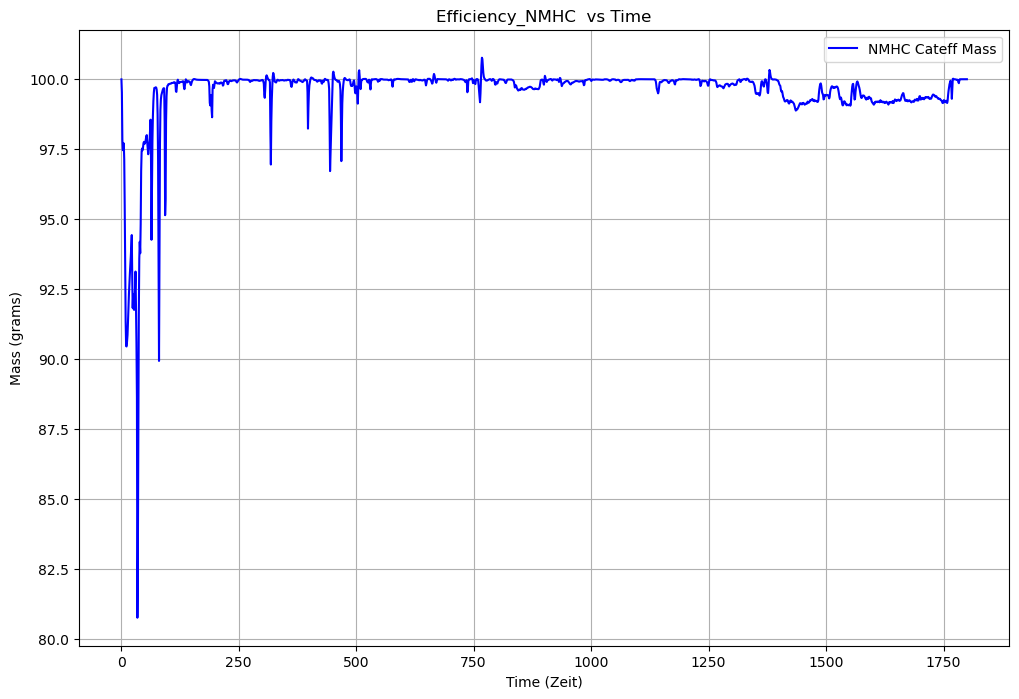

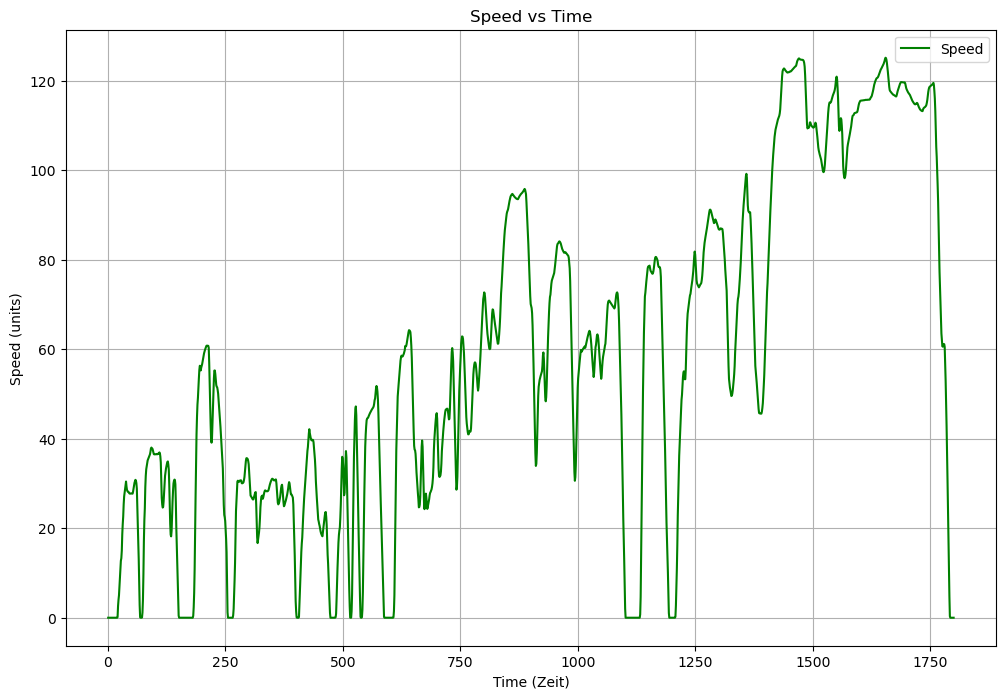

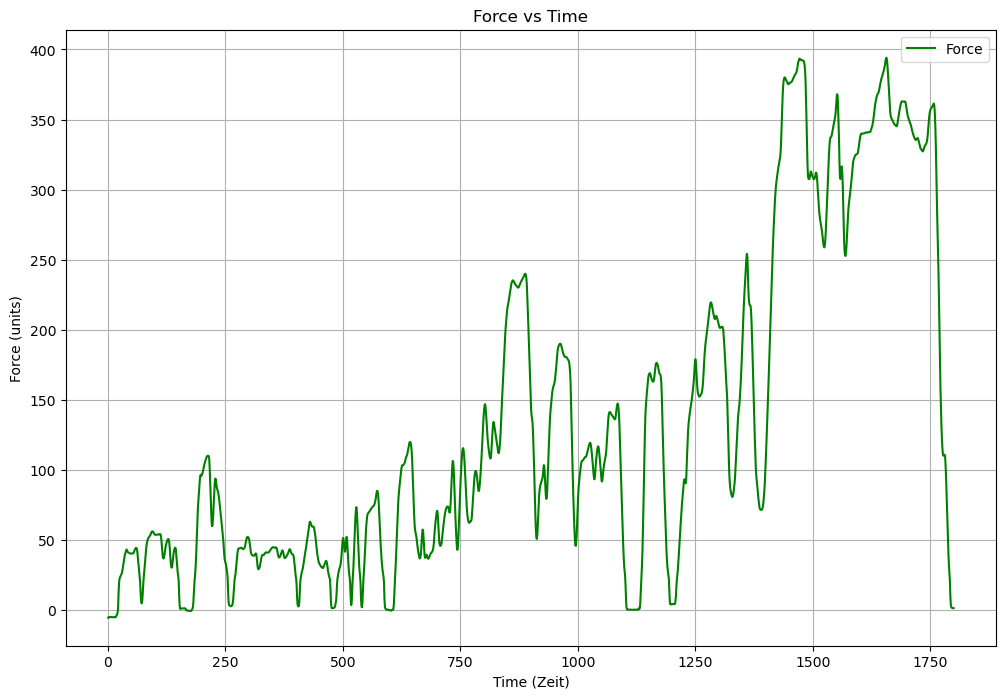

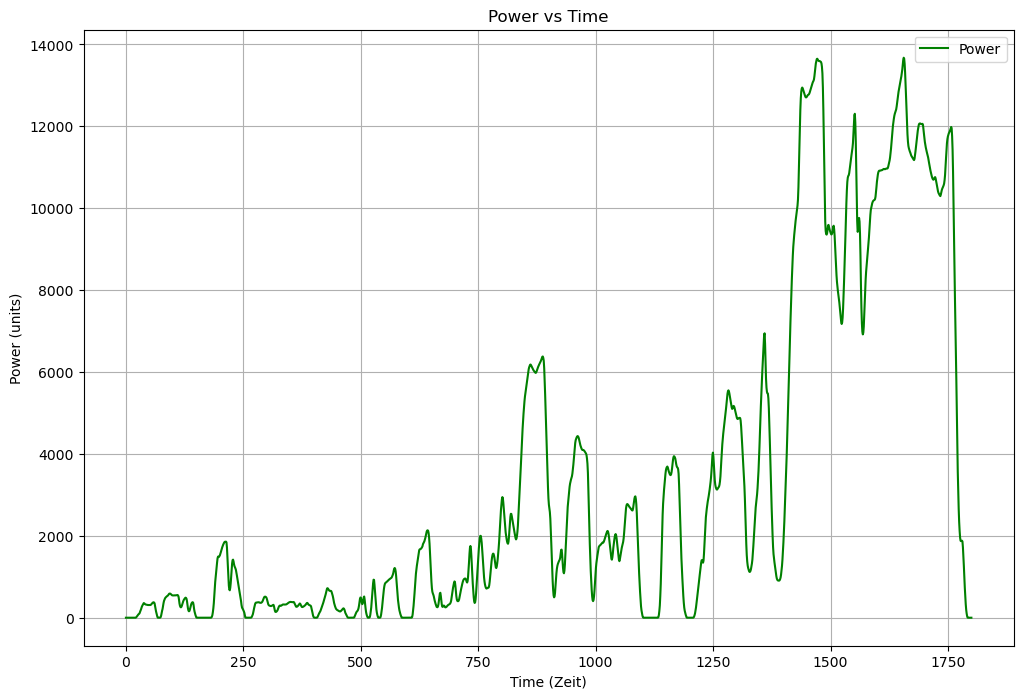

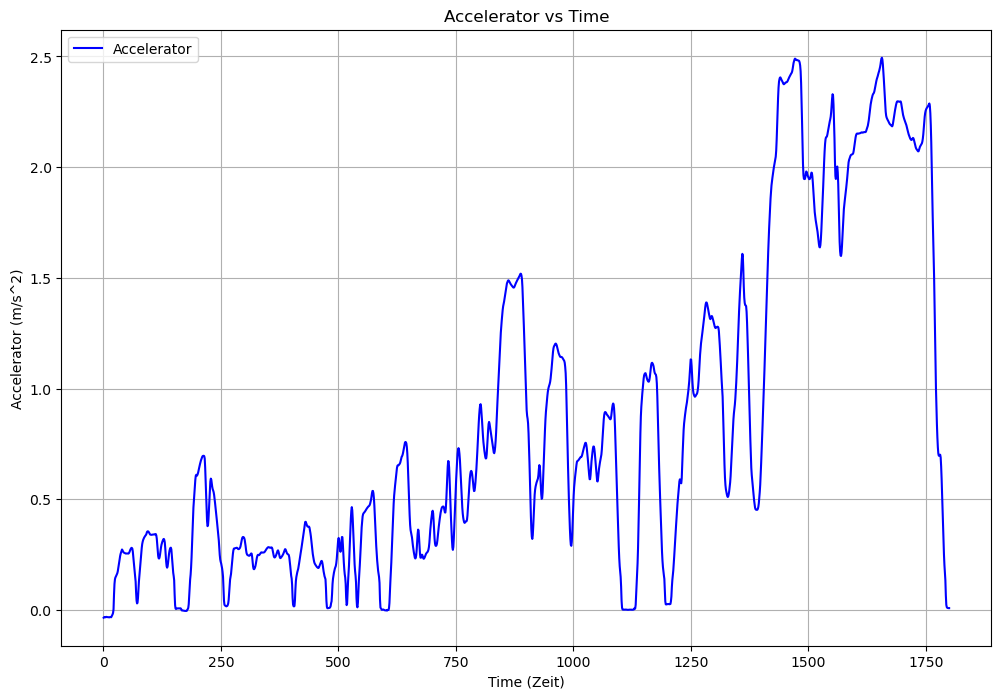

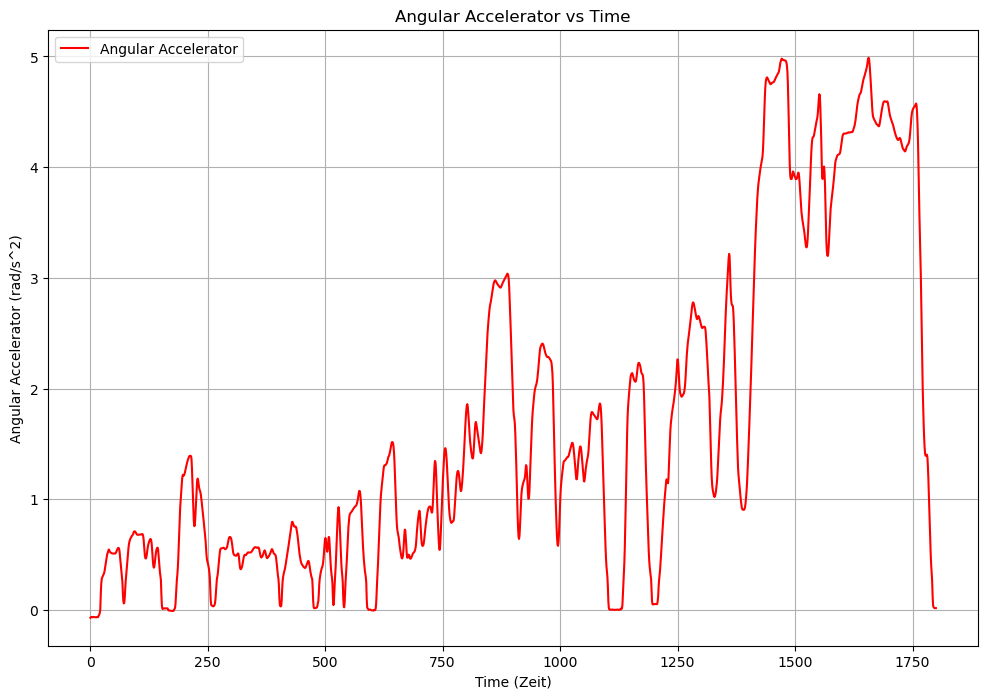

Mean Temperature: 22.388971166666664
Standard Deviation of Temperature: 0.14611236113124532
Minimum Temperature: 22.1361
Maximum Temperature: 22.6092
Variance of Temperature: 0.021348822075347447
Mean Relative Humidity: 51.743475555555555
Standard Deviation of Relative Humidity: 0.8374204288631187
Minimum Relative Humidity: 49.8514
Maximum Relative Humidity: 53.2127
Variance of Relative Humidity: 0.7012729746772897


In [1]:
import pandas as pd
from termcolor import colored
import matplotlib.pyplot as plt
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import os

# File selection dialog
def select_file():
    """Open a file dialog for the user to select a CSV or Excel file."""
    root = Tk()
    root.withdraw()  # Hide the root window
    file_path = askopenfilename(
        title="Select Emission File",
        filetypes=[("CSV Files", "*.csv"), ("Excel Files", "*.xlsx;*.xls"), ("All Files", "*.*")]
    )
    if not file_path:
        print(colored("No file selected. Exiting.", "red", attrs=["bold"]))
        exit()
    return file_path

# Prompt user to select a file
file_path = select_file()

# Determine the file extension and load the file accordingly
file_extension = os.path.splitext(file_path)[1].lower()

if file_extension == ".csv":
    df = pd.read_csv(file_path)
elif file_extension in [".xlsx", ".xls"]:
    df = pd.read_excel(file_path)
else:
    print(colored("Unsupported file format. Exiting.", "red", attrs=["bold"]))
    exit()

# Display the first few rows of the dataset (optional)
print(df.head())


# Ensure column names are clean by removing leading/trailing spaces
df.columns = df.columns.str.strip()

# List of relevant columns
cols = [ 'THC.TailPipe.mass', 'NOX.TailPipe.mass', 
        'CO2.TailPipe.mass', 'CO.TailPipe.mass']  # Including Speed column

# Convert the relevant columns to numeric, with errors coerced to NaN
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Convert Speed from km/h to m/s
df['Speed_mps'] = df['Speed'] * (1000 / 3600)  # Convert Speed from km/h to m/s

# Assuming Force is a column in your data (if not, you need to add it), calculate Power
df['Power'] = df['Force'] * df['Speed_mps']

# Calculate NMHC (Total THC - Methane)
thc_columns = 'THC.TailPipe.mass'
methane_column = 'CH4.Dilute.mass'
df['NMHC'] = df[thc_columns] - df[methane_column]

# Function to calculate sum for a given row range
def calculate_sum(start, end):
    subset = df[cols].iloc[start:end]
    return subset.sum(skipna=True)

# Phase 1: Rows 1 to 601 (index 0 to 600)
sum_1_601 = calculate_sum(0, 600)
print(colored("\n### Sum values for Phase 1 (Rows 1 to 601) ###", "blue", attrs=["bold"]))
print(sum_1_601)

# Phase 2: Rows 601 to 1201 (index 600 to 1200)
sum_601_1201 = calculate_sum(600, 1200)
print(colored("\n### Sum values for Phase 2 (Rows 601 to 1201) ###", "green", attrs=["bold"]))
print(sum_601_1201)

# Phase 3: Rows 1201 to 1801 (index 1200 to 1800)
sum_1201_1801 = calculate_sum(1200, 1800)
print(colored("\n### Sum values for Phase 3 (Rows 1201 to 1801) ###", "cyan", attrs=["bold"]))
print(sum_1201_1801)

# Calculate mean speeds for each phase
speed1 = df['Speed'].iloc[0:600].mean(skipna=True)
speed2 = df['Speed'].iloc[600:1200].mean(skipna=True)
speed3 = df['Speed'].iloc[1200:1800].mean(skipna=True)

# Calculate distances for each phase in kilometers
t = 600 / 3600  # Time in hours (600 seconds)
d1 = speed1 * t
d2 = speed2 * t
d3 = speed3 * t

# Output distances and speed for each phase
print(colored("\n### Distances and Speeds for Each Phase ###", "yellow", attrs=["bold"]))
print(colored(f"Distance in Phase 1: {d1}", "blue"))
print(colored(f"Distance in Phase 2: {d2}", "green"))
print(colored(f"Distance in Phase 3: {d3}", "cyan"))
print(colored(f"Mean Speed for Phase 1: {speed1}", "blue"))
print(colored(f"Mean Speed for Phase 2: {speed2}", "green"))
print(colored(f"Mean Speed for Phase 3: {speed3}", "cyan"))

# Multiply distance by the respective summed values for each phase
multiplied_distance1 = d1 * sum_1_601
multiplied_distance2 = d2 * sum_601_1201
multiplied_distance3 = d3 * sum_1201_1801

# Output multiplied distances for each parameter
print(colored("\n### Multiplied Distances for Each Parameter in Each Phase ###", "magenta", attrs=["bold"]))
print(colored("\nPhase 1:", "blue", attrs=["bold"]))
print(multiplied_distance1)

print(colored("\nPhase 2:", "green", attrs=["bold"]))
print(multiplied_distance2)

print(colored("\nPhase 3:", "cyan", attrs=["bold"]))
print(multiplied_distance3)

# Calculate emissions per kilometer for each parameter in each phase
emissions_per_km_phase1 = sum_1_601 / d1
emissions_per_km_phase2 = sum_601_1201 / d2
emissions_per_km_phase3 = sum_1201_1801 / d3

# Calculate the weighted emissions per kilometer based on the specified percentages
weighted_emissions_per_km_phase1 = emissions_per_km_phase1 * 0.25
weighted_emissions_per_km_phase2 = emissions_per_km_phase2 * 0.50
weighted_emissions_per_km_phase3 = emissions_per_km_phase3 * 0.25

# Sum the weighted emissions per kilometer across all phases
total_weighted_emissions_per_km = weighted_emissions_per_km_phase1 + weighted_emissions_per_km_phase2 + weighted_emissions_per_km_phase3

# Display emissions per kilometer for each phase
print(colored("\n### Emissions per Kilometer for Each Parameter (Weighted by Phase) ###", "yellow", attrs=["bold"]))
print(colored("Phase 1 (25% weight):", "blue", attrs=["bold"]))
print(weighted_emissions_per_km_phase1)

print(colored("\nPhase 2 (50% weight):", "green", attrs=["bold"]))
print(weighted_emissions_per_km_phase2)

print(colored("\nPhase 3 (25% weight):", "cyan", attrs=["bold"]))
print(weighted_emissions_per_km_phase3)

# Display overall weighted emissions per kilometer across all phases
print(colored("\n### Overall Weighted Emissions per Kilometer (Across All Phases) ###", "red", attrs=["bold"]))
print(total_weighted_emissions_per_km)

# Final Total Results
total_results = {
    'Total Summed Phase 1': sum_1_601,
    'Total Summed Phase 2': sum_601_1201,
    'Total Summed Phase 3': sum_1201_1801,
    'Total Distance': d1 + d2 + d3,
    'Weighted Emissions per km Phase 1 (25%)': weighted_emissions_per_km_phase1,
    'Weighted Emissions per km Phase 2 (50%)': weighted_emissions_per_km_phase2,
    'Weighted Emissions per km Phase 3 (25%)': weighted_emissions_per_km_phase3,
    'Overall Weighted Emissions per km': total_weighted_emissions_per_km
}

print(colored("\n### Final Total Results ###", "magenta", attrs=["bold", "underline"]))
for key, value in total_results.items():
    print(f"{colored(key, 'yellow', attrs=['bold'])}: {value}")  
    
    
    
    
    # Define columns with correct names
cols = ['CO.Cateff.mass', 'THC.Cateff.mass', 'NOX.Cateff.mass', 'COH.Cateff.mass', 'CO2.Cateff.mass']

# Convert the relevant columns to numeric, with errors coerced to NaN
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Function to calculate efficiency for a given row range
def calculate_efficiency(start, end):
    subset = df[cols].iloc[start:end]
    return subset.mean(skipna=True)

# Phase 1: Rows 1 to 601 (index 0 to 600)
efficiency_1_601 = calculate_efficiency(0, 600)
print(colored("\n### Efficiency values for Phase 1 (Rows 1 to 601) ###", "blue", attrs=["bold"]))
print(efficiency_1_601)

# Phase 2: Rows 601 to 1201 (index 600 to 1200)
efficiency_601_1201 = calculate_efficiency(600, 1200)
print(colored("\n### Efficiency values for Phase 2 (Rows 601 to 1201) ###", "green", attrs=["bold"]))
print(efficiency_601_1201)

# Phase 3: Rows 1201 to 1801 (index 1200 to 1800)
efficiency_1201_1801 = calculate_efficiency(1200, 1800)
print(colored("\n### Efficiency values for Phase 3 (Rows 1201 to 1801) ###", "cyan", attrs=["bold"]))
print(efficiency_1201_1801)

# Total Efficiency for all phases (average of efficiencies)
total_efficiency = (efficiency_1_601 + efficiency_601_1201 + efficiency_1201_1801) / 3
print(colored("\n### Total Efficiency for all Phases ###", "magenta", attrs=["bold"]))
print(f"Total Efficiency: ",total_efficiency)

# Set a baseline value for NMHC efficiency calculation
baseline_value = 0.07 

# Calculate the efficiency of NMHC reduction
df['Efficiency_NMHC'] = ((baseline_value - df['NMHC']) / baseline_value) * 100

# Display the NMHC efficiency
print(df[['NMHC', 'Efficiency_NMHC']].head())

phase1 = df[df['Zeit'] <= df['Zeit'].quantile(1/3)]  # First third
phase2 = df[(df['Zeit'] > df['Zeit'].quantile(1/3)) & (df['Zeit'] <= df['Zeit'].quantile(2/3))]  # Middle third
phase3 = df[df['Zeit'] > df['Zeit'].quantile(2/3)]  # Last third

# Plot NOX Pre-PrimCat and TailPipe Mass vs Time (Zeit)
plt.figure(figsize=(12, 8))
plt.plot(phase1['Zeit'], phase1['NOX.PrePrimCat.mass'], label='NOX Pre-PrimCat Mass', color='green', linestyle='--')
plt.plot(phase1['Zeit'], phase1['NOX.TailPipe.mass'], label='NOX TailPipe Mass', color='orange')
plt.xlabel('Time (Zeit)')
plt.ylabel('Mass (grams)')
plt.title('Phase 1: NOX Pre-PrimCat and TailPipe Mass vs Time')
plt.legend()
plt.grid(True)
plt.show()
    
plt.figure(figsize=(12, 8))
plt.plot(phase2['Zeit'], phase2['NOX.PrePrimCat.mass'], label='NOX Pre-PrimCat Mass', color='green', linestyle='--')
plt.plot(phase2['Zeit'], phase2['NOX.TailPipe.mass'], label='NOX TailPipe Mass', color='orange')
plt.xlabel('Time (Zeit)')
plt.ylabel('Mass (grams)')
plt.title('Phase 2: NOX Pre-PrimCat and TailPipe Mass vs Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(phase3['Zeit'], phase3['NOX.PrePrimCat.mass'], label='NOX Pre-PrimCat Mass', color='green', linestyle='--')
plt.plot(phase3['Zeit'], phase3['NOX.TailPipe.mass'], label='NOX TailPipe Mass', color='orange')
plt.xlabel('Time (Zeit)')
plt.ylabel('Mass (grams)')
plt.title('Phase 3: NOX Pre-PrimCat and TailPipe Mass vs Time')
plt.legend()
plt.grid(True)
plt.show()
    
# Plot CO Pre-PrimCat and TailPipe Mass vs Time (Zeit)
plt.figure(figsize=(12, 8))
plt.plot(phase1['Zeit'], phase1['CO.PrePrimCat.mass'], label='CO Pre-PrimCat Mass', color='green', linestyle='--')
plt.plot(phase1['Zeit'], phase1['CO.TailPipe.mass'], label='CO TailPipe Mass', color='red')
plt.xlabel('Time (Zeit)')
plt.ylabel('Mass (grams)')
plt.title('Phase 1: CO Pre-PrimCat and TailPipe Mass vs Time')
plt.legend()
plt.grid(True)
plt.show()
    
plt.figure(figsize=(12, 8))
plt.plot(phase2['Zeit'], phase2['CO.PrePrimCat.mass'], label='NOX Pre-PrimCat Mass', color='green', linestyle='--')
plt.plot(phase2['Zeit'], phase2['CO.TailPipe.mass'], label='NOX TailPipe Mass', color='orange')
plt.xlabel('Time (Zeit)')
plt.ylabel('Mass (grams)')
plt.title('Phase 2:CO Pre-PrimCat and TailPipe Mass vs Time')
plt.legend()
plt.grid(True)
plt.show()

    
plt.figure(figsize=(12, 8))
plt.plot(phase3['Zeit'], phase3['CO.PrePrimCat.mass'], label='NOX Pre-PrimCat Mass', color='green', linestyle='--')
plt.plot(phase3['Zeit'], phase3['CO.TailPipe.mass'], label='NOX TailPipe Mass', color='orange')
plt.xlabel('Time (Zeit)')
plt.ylabel('Mass (grams)')
plt.title('Phase 3:CO Pre-PrimCat and TailPipe Mass vs Time')
plt.legend()
plt.grid(True)
plt.show()
    
# Plot THC Pre-PrimCat and TailPipe Mass vs Time (Zeit)
plt.figure(figsize=(12, 8))
plt.plot(phase1['Zeit'], phase1['THC.PrePrimCat.mass'], label='THC Pre-PrimCat Mass', color='green', linestyle='--')
plt.plot(phase1['Zeit'], phase1['THC.TailPipe.mass'], label='THC TailPipe Mass', color='red')
plt.xlabel('Time (Zeit)')
plt.ylabel('Mass (grams)')
plt.title('Phase 1:THC Pre-PrimCat and TailPipe Mass vs Time')
plt.legend()
plt.grid(True)
plt.show()
    
plt.figure(figsize=(12, 8))
plt.plot(phase2['Zeit'], phase2['THC.PrePrimCat.mass'], label='THC Pre-PrimCat Mass', color='green', linestyle='--')
plt.plot(phase2['Zeit'], phase2['THC.TailPipe.mass'], label='THC TailPipe Mass', color='orange')
plt.xlabel('Time (Zeit)')
plt.ylabel('Mass (grams)')
plt.title('Phase 2:THC Pre-PrimCat and TailPipe Mass vs Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(phase3['Zeit'], phase3['THC.PrePrimCat.mass'], label='THC Pre-PrimCat Mass', color='green', linestyle='--')
plt.plot(phase3['Zeit'], phase3['THC.TailPipe.mass'], label='THC TailPipe Mass', color='orange')
plt.xlabel('Time (Zeit)')
plt.ylabel('Mass (grams)')
plt.title('Phase 3:THC Pre-PrimCat and TailPipe Mass vs Time')
plt.legend()
plt.grid(True)
plt.show()


#EFFICIENCY 

# Plot the graph of THC.Cateff.mass vs Zeit
plt.figure(figsize=(12, 8))
# Plot THC.Cateff.mass vs Zeit
plt.plot(df['Zeit'], df['THC.Cateff.mass'], label='THC Cateff Mass', color='blue')
# Add labels and title
plt.xlabel('Time (Zeit)')
plt.ylabel('Mass (grams)')
plt.title('THC Cateff Mass vs Time')
# Add legend
plt.legend()
# Display grid
plt.grid(True)
# Show the plot
plt.show()

# Plot the graph of CO.Cateff.mass vs Zeit
plt.figure(figsize=(12, 8))
# Plot CO.Cateff.mass vs Zeit
plt.plot(df['Zeit'], df['CO.Cateff.mass'], label='CO Cateff Mass', color='blue')
# Add labels and title
plt.xlabel('Time (Zeit)')
plt.ylabel('Mass (grams)')
plt.title('CO Cateff Mass vs Time')
# Add legend
plt.legend()
# Display grid
plt.grid(True)
# Show the plot
plt.show()



# Plot the graph of NOX.Cateff.mass vs Zeit
plt.figure(figsize=(12, 8))
# Plot THC.Cateff.mass vs Zeit
plt.plot(df['Zeit'], df['NOX.Cateff.mass'], label='NOX Cateff Mass', color='blue')
# Add labels and title
plt.xlabel('Time (Zeit)')
plt.ylabel('Mass (grams)')
plt.title('NOX Cateff Mass vs Time')
# Add legend
plt.legend()
# Display grid
plt.grid(True)
# Show the plot
plt.show()



# Plot the graph of THC.Cateff.mass vs Zeit
plt.figure(figsize=(12, 8))
# Plot THC.Cateff.mass vs Zeit
plt.plot(df['Zeit'], df['Efficiency_NMHC'], label='NMHC Cateff Mass', color='blue')
# Add labels and title
plt.xlabel('Time (Zeit)')
plt.ylabel('Mass (grams)')
plt.title('Efficiency_NMHC  vs Time')
# Add legend
plt.legend()
# Display grid
plt.grid(True)
# Show the plot
plt.show()



# Plot the graph of Speed vs Zeit
plt.figure(figsize=(12, 8))
# Plot Speed vs Zeit
plt.plot(df['Zeit'], df['Speed'], label='Speed', color='green')
# Add labels and title
plt.xlabel('Time (Zeit)')  # Label for the x-axis
plt.ylabel('Speed (units)')  # Label for the y-axis (replace 'units' with actual units)
plt.title('Speed vs Time')
# Add legend
plt.legend()
# Display grid
plt.grid(True)
# Show the plot
plt.show()


# Assuming 'Force' is a column in your DataFrame and 'Zeit' is time
plt.figure(figsize=(12, 8))
# Plot Force vs Zeit
plt.plot(df['Zeit'], df['Force'], label='Force', color='green')
# Add labels and title
plt.xlabel('Time (Zeit)')  # Label for the x-axis
plt.ylabel('Force (units)')  # Label for the y-axis (replace 'units' with actual units)
plt.title('Force vs Time')
# Add legend
plt.legend()
# Display grid
plt.grid(True)
# Show the plot
plt.show()


# Assuming 'Power' is a column in your DataFrame and 'Zeit' is time
plt.figure(figsize=(12, 8))
# Plot Power vs Zeit
plt.plot(df['Zeit'], df['Power'], label='Power', color='green')
# Add labels and title
plt.xlabel('Time (Zeit)')  # Label for the x-axis
plt.ylabel('Power (units)')  # Label for the y-axis (replace 'units' with actual units)
plt.title('Power vs Time')
# Add legend
plt.legend()
# Display grid
plt.grid(True)
# Show the plot
plt.show()


# the vehicle mass (for example, in kg)
vehicle_mass = 158  # Example mass in kg (you can change this as needed)
# Calculate acceleration
df['Accelerator'] = df['Force'] / vehicle_mass
# Plot Accelerator vs Time
plt.figure(figsize=(12, 8))
# Plot Accelerator vs Zeit
plt.plot(df['Zeit'], df['Accelerator'], label='Accelerator', color='blue')
# Add labels and title
plt.xlabel('Time (Zeit)')  # Label for the x-axis
plt.ylabel('Accelerator (m/s^2)')  # Acceleration in meters per second squared
plt.title('Accelerator vs Time')
# Add legend
plt.legend()
# Display grid
plt.grid(True)
# Show the plot
plt.show()



# Example: Assume radius is known (e.g., 0.5 meters)
radius = 0.5  # meters
# Assuming moment of inertia (for example, for a solid disk, I = m * r^2, where m = vehicle_mass)
vehicle_mass = 158  # kg (replace with the actual mass of the vehicle)
moment_of_inertia = vehicle_mass * radius**2  # simplified assumption for a solid disk
# Calculate angular acceleration (alpha)
df['Angular_Accelerator'] = (df['Force'] * radius) / moment_of_inertia
# Plot Angular Accelerator vs Time
plt.figure(figsize=(12, 8))
# Plot Angular Accelerator vs Zeit
plt.plot(df['Zeit'], df['Angular_Accelerator'], label='Angular Accelerator', color='red')
# Add labels and title
plt.xlabel('Time (Zeit)')  # Label for the x-axis
plt.ylabel('Angular Accelerator (rad/s^2)')  # Angular acceleration in radians per second squared
plt.title('Angular Accelerator vs Time')
# Add legend
plt.legend()
# Display grid
plt.grid(True)
# Show the plot
plt.show()


# Calculate statistical measures for CellTemp column
mean_temp = df['CellTemp'].mean()  # Mean temperature
std_temp = df['CellTemp'].std()    # Standard deviation
min_temp = df['CellTemp'].min()    # Minimum temperature
max_temp = df['CellTemp'].max()    # Maximum temperature
variance_temp = df['CellTemp'].var()  # Variance

# Print the results
print(f"Mean Temperature: {mean_temp}")
print(f"Standard Deviation of Temperature: {std_temp}")
print(f"Minimum Temperature: {min_temp}")
print(f"Maximum Temperature: {max_temp}")
print(f"Variance of Temperature: {variance_temp}")
# Calculate statistical measures for HumsRel (Relative Humidity) column
mean_humidity = df['HumsRel'].mean()  # Mean relative humidity
std_humidity = df['HumsRel'].std()    # Standard deviation
min_humidity = df['HumsRel'].min()    # Minimum relative humidity
max_humidity = df['HumsRel'].max()    # Maximum relative humidity
variance_humidity = df['HumsRel'].var()  # Variance

# Print the results
print(f"Mean Relative Humidity: {mean_humidity}")
print(f"Standard Deviation of Relative Humidity: {std_humidity}")
print(f"Minimum Relative Humidity: {min_humidity}")
print(f"Maximum Relative Humidity: {max_humidity}")
print(f"Variance of Relative Humidity: {variance_humidity}")



In [2]:
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph
from reportlab.lib.styles import getSampleStyleSheet

# Function to save results to a PDF in table format
def save_results_to_pdf(results, filename='emission_analysis.pdf'):
    pdf = SimpleDocTemplate(filename, pagesize=letter)
    elements = []

    styles = getSampleStyleSheet()
    
    # Title
    title = Paragraph("Emission Analysis Output 3_2 CYCLE", styles['Title'])
    elements.append(title)

    # Prepare data for tables
    for section, content in results.items():
        elements.append(Paragraph(section, styles['Heading2']))
        
        # Create a table from content
        data = [["Parameter", "Value"]]  # Table header
        
        for item in content:
            data.append(item)  # Append each item as a row

        # Create the table
        table = Table(data)
        # Set table style
        table.setStyle(TableStyle([
            ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
            ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
            ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
            ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
            ('GRID', (0, 0), (-1, -1), 1, colors.black),
        ]))
        
        elements.append(table)
        elements.append(Paragraph("<br/>", styles['Normal']))  # Add a space between sections

    # Build PDF
    pdf.build(elements)
    
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt


# Initialize PdfPages to save all plots to a single PDF
filename = "3_2output_plots.pdf"
with PdfPages(filename) as pdf:
    # Plot THC Pre-PrimCat and TailPipe Mass vs Time (Zeit)
    plt.figure(figsize=(12, 8))
    plt.plot(df['Zeit'], df['THC.PrePrimCat.mass'], label='THC Pre-PrimCat Mass', color='blue', linestyle='--')
    plt.plot(df['Zeit'], df['THC.TailPipe.mass'], label='THC TailPipe Mass', color='red')
    plt.xlabel('Time (Zeit)')
    plt.ylabel('Mass (grams)')
    plt.title('THC Pre-PrimCat and TailPipe Mass vs Time')
    plt.legend()
    plt.grid(True)
    pdf.savefig()  # Save the current figure to the PDF
    plt.close()

    # Plot CO Pre-PrimCat and TailPipe Mass vs Time (Zeit)
    plt.figure(figsize=(12, 8))
    plt.plot(df['Zeit'], df['CO.PrePrimCat.mass'], label='CO Pre-PrimCat Mass', color='blue', linestyle='--')
    plt.plot(df['Zeit'], df['CO.TailPipe.mass'], label='CO TailPipe Mass', color='red')
    plt.xlabel('Time (Zeit)')
    plt.ylabel('Mass (grams)')
    plt.title('CO Pre-PrimCat and TailPipe Mass vs Time')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()
    
    # Plot NOX Pre-PrimCat and TailPipe Mass vs Time (Zeit)
    plt.figure(figsize=(12, 8))
    plt.plot(df['Zeit'], df['NOX.PrePrimCat.mass'], label='NOX Pre-PrimCat Mass', color='green', linestyle='--')
    plt.plot(df['Zeit'], df['NOX.TailPipe.mass'], label='NOX TailPipe Mass', color='orange')
    plt.xlabel('Time (Zeit)')
    plt.ylabel('Mass (grams)')
    plt.title('NOX Pre-PrimCat and TailPipe Mass vs Time')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()
    


    # Efficiency: THC Cateff Mass vs Zeit
    plt.figure(figsize=(12, 8))
    plt.plot(df['Zeit'], df['THC.Cateff.mass'], label='THC Cateff Mass', color='blue')
    plt.xlabel('Time (Zeit)')
    plt.ylabel('Mass (grams)')
    plt.title('THC Cateff Mass vs Time')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()
    
    # Plot the graph of CO.Cateff.mass vs Zeit
    plt.figure(figsize=(12, 8))
    plt.plot(df['Zeit'], df['CO.Cateff.mass'], label='CO Cateff Mass', color='blue')
    plt.xlabel('Time (Zeit)')
    plt.ylabel('Mass (grams)')
    plt.title('CO Cateff Mass vs Time')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()


    # Efficiency: NOX Cateff Mass vs Zeit
    plt.figure(figsize=(12, 8))
    plt.plot(df['Zeit'], df['NOX.Cateff.mass'], label='NOX Cateff Mass', color='blue')
    plt.xlabel('Time (Zeit)')
    plt.ylabel('Mass (grams)')
    plt.title('NOX Cateff Mass vs Time')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()

    # Efficiency: NMHC vs Zeit
    plt.figure(figsize=(12, 8))
    plt.plot(df['Zeit'], df['Efficiency_NMHC'], label='NMHC Cateff Mass', color='blue')
    plt.xlabel('Time (Zeit)')
    plt.ylabel('Mass (grams)')
    plt.title('Efficiency_NMHC vs Time')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()

    # Speed vs Zeit
    plt.figure(figsize=(12, 8))
    plt.plot(df['Zeit'], df['Speed'], label='Speed', color='green')
    plt.xlabel('Time (Zeit)')
    plt.ylabel('Speed (units)')
    plt.title('Speed vs Time')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()

    # Force vs Zeit
    plt.figure(figsize=(12, 8))
    plt.plot(df['Zeit'], df['Force'], label='Force', color='green')
    plt.xlabel('Time (Zeit)')
    plt.ylabel('Force (units)')
    plt.title('Force vs Time')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()

    # Power vs Zeit
    plt.figure(figsize=(12, 8))
    plt.plot(df['Zeit'], df['Power'], label='Power', color='green')
    plt.xlabel('Time (Zeit)')
    plt.ylabel('Power (units)')
    plt.title('Power vs Time')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()

    # Accelerator vs Zeit
    vehicle_mass = 158  # Example mass in kg
    df['Accelerator'] = df['Force'] / vehicle_mass
    plt.figure(figsize=(12, 8))
    plt.plot(df['Zeit'], df['Accelerator'], label='Accelerator', color='blue')
    plt.xlabel('Time (Zeit)')
    plt.ylabel('Accelerator (m/s^2)')
    plt.title('Accelerator vs Time')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()

    # Angular Accelerator vs Zeit
    plt.figure(figsize=(12, 8))
    plt.plot(df['Zeit'], df['Angular_Accelerator'], label='Angular Accelerator', color='red')
    plt.xlabel('Time (Zeit)')
    plt.ylabel('Angular Accelerator (rad/s^2)')
    plt.title('Angular Accelerator vs Time')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()

print(f"Plots saved successfully to {filename}")


    

# Prepare your results in a structured format

# Prepare your results in a structured format
results_dict = {

    "Distances and Speeds for Each Phase": [
        ["Distance in Phase 1 (km)", str(d1)],
        ["Distance in Phase 2 (km)", str(d2)],
        ["Distance in Phase 3 (km)", str(d3)],
        [" Total Distance in Phases(km)", str(d1+d2+d3)],
        
        ["Mean Speed for Phase 1 (km/h)", str(speed1)],
        ["Mean Speed for Phase 2 (km/h)", str(speed2)],
        ["Mean Speed for Phase 3 (km/h)", str(speed3)],
    ],# Add mean speed for phase 3
      "Emissions per kilometer": [
        ["PHASE 1:Emissions Per Kilometer for each Parameter", str(emissions_per_km_phase1)],
        ["PHASE 2:Emissions Per kilometer for each Parameter", str(emissions_per_km_phase2)],
        ["PHASE 3:Emissions Per kilometer for each Parameter", str(emissions_per_km_phase3)],
        
       
        
    ],
    "total_weighted_emissions_per_km": [
        ["Parameter", "Weighted Emission per km"],
        ["THC", str(total_weighted_emissions_per_km['THC.TailPipe.mass'])],
        ["NOX", str(total_weighted_emissions_per_km['NOX.TailPipe.mass'])],
        ["CO2", str(total_weighted_emissions_per_km['CO2.TailPipe.mass'])],
        ["CO", str(total_weighted_emissions_per_km['CO.TailPipe.mass'])],
        
    ],
    "Efficiency values": [
        ["Efficiency values for Phase 1", str(efficiency_1_601)],
        ["Efficiency values for Phase 2", str(efficiency_601_1201)],
        ["Efficiency values for Phase 3", str(efficiency_1201_1801)],  
           
    ],
    "Total Efficiency for all Phases ":[
        ['Total Efficiency  ', str(total_efficiency)],
    ],
    
    "statistical measures for Cell Temperature": [
        ["Mean temperature", str(mean_temp)],
        ["Standard deviation", str(std_temp)],
        ["Minimum temperature", str(min_temp)],
        ["Maximum temperature", str(max_temp)],
        [" Variance", str(variance_temp)],
     ],
    
    
     " statistical measures for Relative Humidity": [
        ["Mean relative humidity", str(mean_humidity)],
        ["Standard deviation", str(std_humidity)],
        ["Minimum relative humidity", str(min_humidity)],
        ["Maximum relative humidity", str(max_humidity)],
        [" Variance", str(variance_humidity)],
      ],
        
}
    
#Open a PdfPages object to save the plots
# Save results to tabular PDF
save_results_to_pdf(results_dict, '3_2 emissiontable.pdf')







Plots saved successfully to 3_2output_plots.pdf


In [3]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib import colors  # Import the colors module
from datetime import datetime
from PyPDF2 import PdfMerger

class HeaderFooterCanvas(canvas.Canvas):
    def __init__(self, vehicle_model, driver_name, rider_weight, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.width, self.height = letter
        self.vehicle_model = vehicle_model
        self.driver_name = driver_name
        self.rider_weight = rider_weight
        self.department = "2WP/IN"
        self.lab = "BOSCH Ltd. Vehicle Test Lab"
        self.name_of_cycle = "WMTC_CLASS_3_2"
        self.date_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    def add_header(self):
        # Set color for header title
        self.setFont("Helvetica-Bold", 14)
        self.setFillColorRGB(0.1, 0.5, 0.8)  # Blue color
        self.drawCentredString(self.width / 2, self.height - 50, "Chassis Dyno")

        # Set color for header details
        self.setFont("Helvetica", 12)
        self.setFillColorRGB(0, 0, 0)  # Black color
        self.drawString(50, self.height - 100, f"Date and Time: {self.date_time}")
        self.drawString(50, self.height - 120, f"Vehicle Model: {self.vehicle_model}")
        self.drawString(50, self.height - 140, f"Driver Name: {self.driver_name}")
        self.drawString(50, self.height - 160, f"Rider Weight: {self.rider_weight} kg")
        self.drawString(50, self.height - 180, f"Department: {self.department}")
        self.drawString(50, self.height - 200, f"Lab: {self.lab}")
        self.drawString(50, self.height - 220, f"Name of the Cycle: {self.name_of_cycle}")

    def showPage(self):
        # Ensure header is added on each page
        self.add_header()
        super().showPage()

# Generate a PDF file
def generate_pdf(output_file, vehicle_model, driver_name, rider_weight):
    pdf = HeaderFooterCanvas(vehicle_model, driver_name, rider_weight, output_file, pagesize=letter)
    
    # Add content for the single page
    pdf.setFont("Helvetica", 10)
    pdf.setFillColorRGB(0.3, 0.7, 0.3)  # Green color for the content text
    pdf.drawString(50, 500, "")
    
    # Add header explicitly before finalizing the page
    pdf.add_header()
    
    # Save the document after adding all content
    pdf.save()

# Prompt the user for input
vehicle_model = input("Enter the vehicle model: ")
driver_name = input("Enter the driver's name: ")
rider_weight = float(input("Enter the rider's weight (in kg): "))

# Generate the PDF with the user inputs
output_file = "chassis_dyno_report.pdf"
generate_pdf(output_file, vehicle_model, driver_name, rider_weight)

print(f"PDF '{output_file}' generated successfully.")




# Paths to the PDF files

pdf_file1 = "chassis_dyno_report.pdf"  # First PDF file
pdf_file2 = "3_2 emissiontable.pdf"   # Second PDF file
pdf_file3 =  "3_2output_plots.pdf"    # Third PDF file
merged_file = "3_2Final_output.pdf"    # Output merged PDF file


# Create a PdfMerger object
merger = PdfMerger()

# Append the PDFs in the desired order
merger.append(pdf_file1)  # Add the first file
merger.append(pdf_file2)  # Add the second file
merger.append(pdf_file3)  # Add the third file

# Write the merged PDF to a new file
merger.write(merged_file)  # Save the merged PDF
merger.close()  # Close the PdfMerger object

print(f"PDF files merged successfully into {merged_file}")

Enter the vehicle model: r15
Enter the driver's name: punya
Enter the rider's weight (in kg): 78
PDF 'chassis_dyno_report.pdf' generated successfully.
PDF files merged successfully into 3_2Final_output.pdf
